In [1]:
def unpickle(file):
    import pickle
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding = "bytes")
    return dict

In [2]:
tmp = unpickle("../data/CIFAR10/cifar-10-batches-py/data_batch_1")
print(tmp.keys())
print(tmp[b'data'].shape)

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
(10000, 3072)


In [3]:
def batch_to_data(root):
    data = unpickle(root)
    data_images = data[b"data"] / 255
    data_images = data_images.reshape(-1, 3, 32, 32).astype("float32")
    data_labels = data[b"labels"]
    return data_images, data_labels

In [4]:
images1, label1 = batch_to_data("../data/CIFAR10/cifar-10-batches-py/data_batch_1")
images2, label2 = batch_to_data("../data/CIFAR10/cifar-10-batches-py/data_batch_2")
images3, label3 = batch_to_data("../data/CIFAR10/cifar-10-batches-py/data_batch_3")
images4, label4 = batch_to_data("../data/CIFAR10/cifar-10-batches-py/data_batch_4")
images5, label5 = batch_to_data("../data/CIFAR10/cifar-10-batches-py/data_batch_5")
test_images, test_labels = batch_to_data("../data/CIFAR10/cifar-10-batches-py/test_batch")

In [5]:
import numpy as np
train_images = np.concatenate([images1, images2, images3, images4, images5], axis = 0)
train_labels = np.concatenate([label1, label2, label3, label4, label5], axis = 0)
test_labels = np.concatenate([test_labels], axis = 0)

In [6]:
# Split Train, Validation Set
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, stratify = train_labels, random_state = 42, test_size = 0.2)

In [7]:
# Check Images
print("The Shape of Train Images: ", train_images.shape)
print("The Shape of Valid Images: ", valid_images.shape)
print("The Shape of Test Images: ", test_images.shape)

The Shape of Train Images:  (40000, 3, 32, 32)
The Shape of Valid Images:  (10000, 3, 32, 32)
The Shape of Test Images:  (10000, 3, 32, 32)


In [8]:
# Check Labels
print("The Number of Train Labels: ", train_labels.shape)
print("The Number of Valid Labels: ", valid_labels.shape)
print("The Number of Test Labels: ", test_labels.shape)

The Number of Train Labels:  (40000,)
The Number of Valid Labels:  (10000,)
The Number of Test Labels:  (10000,)


In [9]:
# Make DataLoader with TensorDataset
import torch
from torch.utils.data import TensorDataset, DataLoader
train_images_tensor = torch.tensor(train_images)
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_tensor, batch_size = 64, num_workers = 0, shuffle = True)

valid_images_tensor = torch.tensor(valid_images)
valid_labels_tensor = torch.tensor(valid_labels)
valid_tensor = TensorDataset(valid_images_tensor, valid_labels_tensor)
valid_loader = DataLoader(valid_tensor, batch_size = 64, num_workers = 0, shuffle = True)

test_images_tensor = torch.tensor(test_images)

In [10]:
# Make CNN Architecture
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = 1, padding_mode = "zeros")
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1, padding_mode = "zeros")
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x) # 32 * 32 * 3
        x = F.relu(x)     # 32 * 32 * 3
        x = self.pool(x)  # 16 * 16 * 3
        x = self.conv2(x) # 16 * 16 * 16
        x = F.relu(x)     # 16 * 16 * 16
        x = self.pool(x)  #  8 *  8 * 16
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
model = CNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
print("Model: ", model)
print("Device: ", DEVICE)

Model:  CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
Device:  cuda


In [12]:
# Define Train & Evaluate
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE, dtype = torch.int64)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def evaluate(model, valid_loader):
    model.eval()
    
    valid_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(DEVICE), target.to(DEVICE, dtype = torch.int64)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction = "sum").item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    return valid_loss, valid_accuracy

In [14]:
'''TRAINING'''
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    valid_loss, valid_accuracy = evaluate(model, valid_loader)
    print("[EPOCH: {}], \tValidation Loss: {:.4f}, \tValidation Accuracy: {:.2f} %\n".format(
        epoch, valid_loss, valid_accuracy))

c:\users\justin\venv\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/40000 (0%)]	Loss: 2.309410
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.074328
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.949840
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.804405
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.731735
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.595117
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.696486
[EPOCH: 1], 	Validation Loss: 1.5815, 	Validation Accuracy: 42.64 %

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.603365
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.544948
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.324980
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.442722
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.641744
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.755652
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.377651
[EPOCH: 2], 	Validation Loss: 1.4904, 	Validation Accuracy: 45.53 %

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.609147
Train Epoch: 3 [6400/40000 (16%)]	Loss: 1.512689
Train Epoch: 3 [12800/40000 (32%)]	Loss: 1.594874
Train Epoch: 3 [19200/40000 (4

In [15]:
def testset_prediction(model, test_images_tensor):
    model.eval()
    result = []
    with torch.no_grad():
        for data in test_images_tensor:
            data = data.to(DEVICE)
            output = model(data.view(-1, 3, 32, 32))
            prediction = output.max(1, keepdim = True)[1]
            result.append(prediction.tolist())
    return result

In [16]:
from sklearn.metrics import accuracy_score
test_predict_result = testset_prediction(model, test_images_tensor)
accuracy_score(test_labels, np.squeeze(test_predict_result))

c:\users\justin\venv\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.5916

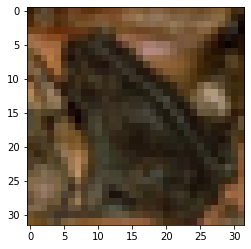

In [18]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(test_images[30], (1, 2, 0)))
plt.show()